<a href="https://colab.research.google.com/github/MichalSlowakiewicz/Machine-Learning/blob/master/Homework9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework Assignment - *Do Androids Dream of Electric Sheep?***

-------------------------------------  

"Do Androids Dream of Electric Sheep?" – the famous title of Philip K. Dick’s novel – raises a fascinating question: if artificial intelligence could dream, what would it see?  

In this assignment, we explore a phenomenon known as **neural network dreams**, where instead of optimizing a neural network's weights, we **optimize the input itself** to achieve a desired classification outcome. Given a fully trained MNIST classification network, your goal is to manipulate its inputs so that it confidently predicts each digit from 0 to 9, starting from pure noise.  

## **Tasks Description**  

During this class we designed and trained a **MNIST classification neural network**, which takes a **batch of grayscale images** of size **$28 \times 28$** as input and outputs a probability distribution over the 10 digit classes (0–9). However, instead of using real MNIST images, you will **treat the input batch itself as a set of trainable parameters** and optimize it so that the network classifies each image as a specific digit.  

1. Your first task is to generate **a batch of 10 images**, where each image is
   classified as one of the digits **0, 1, 2, ..., 9**, starting from an initial batch of ten random Gaussian noise images.  

   Discuss the following question: do the generated images resemble real MNIST digits? Why or why not?  

2. Discuss, how you would approach a second task of
   generating an image that   
   bares similarity to two or more digits simultaneously. **Implement your idea to see the results.**

3. Third task: repeat the previous tasks with an additional L2 penalty on noise within the images. Experiment with adding `lambda_l2 * dreamed_input_batch.pow(2).mean()` loss term, with `lambda_l2` being the penalty cooefficient within an exponential progression, say from 0.001 to 10.0. Are the new digits recognized correctly? How does the penalty impact the digit quality? Explain.

### **Optimization Process for Task 1**  

1. Start with a **batch of 10 random Gaussian noise images** as the initial input and $(0, 1, 2, \ldots, 9)$ as the expected output batch of target digits.  
2. Define the objective: maximize the neural network's confidence for the corresponding target digit for each image in the batch.  
3. Use **gradient descent** to modify the pixels in each image, making the network classify each one as the assigned digit.  
4. Repeat until the network assigns suffieciently high confidence to each image’s target class.  

### **Implementation Details**  

- The neural network weights **must remain frozen** during optimization. You are modifying only the input images.  
- The loss function should be the **cross-entropy loss** between the predicted probabilities and the desired class labels (plus an optional weighted L2 penalty regularizing the images in task 3).


## **Points to Note**  

1. **Visualize** the optimization process: Save images of the generated inputs at different steps and plot the classification confidence evolution over iterations.  
3. **Document your findings** and explain the behavior you observe.  

## **Task & Deliverables**  

- A **Colab notebook** containing solutions for both tasks:
  - The full implementation.
  - Visualizations of the generated batch of images.
  - A written explanation of your observations.
- **Bonus:** If you create an **animation** showing the evolution of the input images during optimization, it will be considered a strong enhancement to your submission.
  - You can generate an animation programmatically (e.g., using Matplotlib or OpenCV).
  - Or, save image frames and use external tools to create a video.
  - Provide a **link** to any video files in the README.
- Upload your notebook and results to your **GitHub repository** for the course.
- In the **README**, include a **link** to the notebook.
- In the notebook, include **“Open in Colab”** badge so it can be launched directly.




In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt


# reading MNIST dataset
trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=None)

# mean and std of dataset
mean_dataset = trainset.data.numpy().mean()/255.0
std_dataset = trainset.data.numpy().std()/255.0

transform = torchvision.transforms.Compose(
    [ torchvision.transforms.ToTensor(), #Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
      torchvision.transforms.Normalize((mean_dataset), (std_dataset))])

trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=2048,
                                          shuffle=True)   #we do shuffle it to give more randomizations to training epochs

testset = torchvision.datasets.MNIST(root='./data',
                                     train=False,
                                     download=True,
                                     transform=transform)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=1,
                                         shuffle=False)


class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = torch.nn.ReLU()
        self.flatten = torch.nn.Flatten()

        # Define all layers explicitly
        self.linear1 = torch.nn.Linear(1*28*28, 1024)  # First linear layer
        self.linear2 = torch.nn.Linear(1024, 2048)     # Second linear layer
        self.linear3 = torch.nn.Linear(2048, 256)      # Third linear layer
        self.linear4 = torch.nn.Linear(256, 10)        # Final linear layer (no activation)

        self.dropout = torch.nn.Dropout(0.05)

    def forward(self, x):      # Input shape: (B, 1, 28, 28)
        x = self.flatten(x)    # Shape: (B, 784)

        # Pass through all layers with ReLU activation
        x = self.relu(self.linear1(x))  # Shape: (B, 1024)
        x = self.relu(self.linear2(x))  # Shape: (B, 2048)
        x = self.relu(self.linear3(x))  # Shape: (B, 256)
        x = self.linear4(x)             # Shape: (B, 10) - no activation

        x = self.dropout(x)
        return x

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 473kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.47MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.61MB/s]


In [2]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on {device}")

net = MLP().to(device)
optimizer = torch.optim.Adam(net.parameters(), 0.001)   #initial and fixed learning rate of 0.001.

net.train()    #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing traning
for epoch in range(8):  #  an epoch is a training run through the whole data set

    for batch, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        batch_inputs = batch_inputs.to(device)  #explicitly moving the data to the target device
        batch_labels = batch_labels.to(device)

        #batch_inputs.squeeze(1)     #alternatively if not for a Flatten layer, squeeze() could be used to remove the second order of the tensor, the Channel, which is one-dimensional (this index can be equal to 0 only)

        optimizer.zero_grad()

        batch_outputs = net(batch_inputs)   #this line calls the forward(self, x) method of the MLP object. Please note, that the last layer of the MLP is linear
                                            #and MLP doesn't apply
                                            #the nonlinear activation after the last layer
        loss = torch.nn.functional.cross_entropy(batch_outputs, batch_labels, reduction = "mean") #instead, nonlinear softmax is applied internally in THIS loss function
        print("epoch:", epoch, "batch:", batch, "current batch loss:", loss.item())
        loss.backward()       #this computes gradients as we have seen in previous workshops
        optimizer.step()     #but this line in fact updates our neural network.
                                ####You can experiment - comment this line and check, that the loss DOE

Working on cuda
epoch: 0 batch: 0 current batch loss: 2.3052256107330322
epoch: 0 batch: 1 current batch loss: 2.0715997219085693
epoch: 0 batch: 2 current batch loss: 1.6050604581832886
epoch: 0 batch: 3 current batch loss: 1.0206862688064575
epoch: 0 batch: 4 current batch loss: 0.931948184967041
epoch: 0 batch: 5 current batch loss: 1.6821260452270508
epoch: 0 batch: 6 current batch loss: 1.6626542806625366
epoch: 0 batch: 7 current batch loss: 1.027954339981079
epoch: 0 batch: 8 current batch loss: 0.6751056909561157
epoch: 0 batch: 9 current batch loss: 0.9559221267700195
epoch: 0 batch: 10 current batch loss: 0.7759411931037903
epoch: 0 batch: 11 current batch loss: 0.7173763513565063
epoch: 0 batch: 12 current batch loss: 0.5863138437271118
epoch: 0 batch: 13 current batch loss: 0.594666063785553
epoch: 0 batch: 14 current batch loss: 0.5850574374198914
epoch: 0 batch: 15 current batch loss: 0.6180981993675232
epoch: 0 batch: 16 current batch loss: 0.5852257013320923
epoch: 0 ba

In [3]:
good = 0
wrong = 0

net.eval()              #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing evaluation
with torch.no_grad():   #it prevents that the net learns during evalution. The gradients are not computed, so this makes it faster, too
    for batch, data in enumerate(testloader): #batches in test are of size 1
        datapoint, label = data

        prediction = net(datapoint.to(device))                  #prediction has values representing the "prevalence" of the corresponding class
        classification = torch.argmax(prediction)    #the class is the index of maximal "prevalence"

        if classification.item() == label.item():
            good += 1
        else:
            wrong += 1

print("accuracy = ", good/(good+wrong))

accuracy =  0.9805


Step 0, Loss: 2.3084, Confidence: [0.1, 0.098, 0.096, 0.104, 0.105, 0.095, 0.095, 0.098, 0.105, 0.098]
Step 50, Loss: 0.6749, Confidence: [0.559, 0.476, 0.514, 0.501, 0.631, 0.538, 0.37, 0.56, 0.541, 0.449]
Step 100, Loss: 0.1841, Confidence: [0.859, 0.828, 0.836, 0.838, 0.885, 0.839, 0.731, 0.869, 0.846, 0.797]
Step 150, Loss: 0.0860, Confidence: [0.931, 0.917, 0.919, 0.925, 0.942, 0.917, 0.867, 0.936, 0.923, 0.901]
Step 200, Loss: 0.0520, Confidence: [0.958, 0.949, 0.95, 0.954, 0.963, 0.948, 0.92, 0.961, 0.952, 0.939]
Step 250, Loss: 0.0357, Confidence: [0.971, 0.965, 0.965, 0.968, 0.974, 0.964, 0.945, 0.973, 0.966, 0.958]
Step 300, Loss: 0.0264, Confidence: [0.979, 0.974, 0.974, 0.976, 0.98, 0.973, 0.96, 0.98, 0.975, 0.969]
Step 350, Loss: 0.0206, Confidence: [0.983, 0.98, 0.98, 0.981, 0.985, 0.979, 0.969, 0.984, 0.98, 0.976]
Step 400, Loss: 0.0166, Confidence: [0.987, 0.984, 0.984, 0.985, 0.988, 0.983, 0.975, 0.987, 0.984, 0.981]
Step 450, Loss: 0.0137, Confidence: [0.989, 0.986, 0

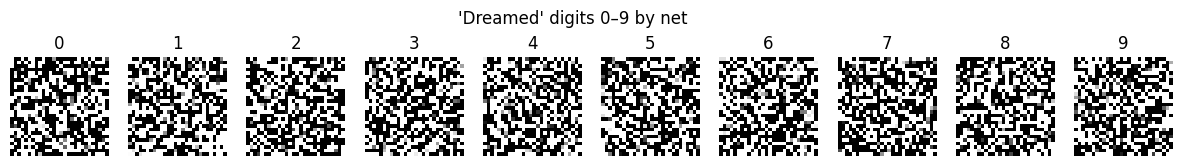

In [42]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# freezeing weights
net.eval()
#for param in net.parameters():
#    param.requires_grad = False

# gaussian noise as input
dreamed_inputs = torch.randn((10, 1, 28, 28), device=device, requires_grad=True)

# i-th image -> i-th number
target_classes = torch.arange(10, device=device)

# optimizer for input
optimizer = torch.optim.Adam([dreamed_inputs], lr=0.1)

# for further normalizing
mean_tensor = torch.tensor(mean_dataset, device=device)
std_tensor = torch.tensor(std_dataset, device=device)

# optimalization
for step in range(1000):
    optimizer.zero_grad()

    # normalizing input
    #normalized_inputs = (dreamed_inputs - mean_tensor) / std_tensor

    logits = net(dreamed_inputs)
    loss = F.cross_entropy(logits, target_classes)

    loss.backward()
    optimizer.step()

    if step % 50 == 0 or step == 999:
        with torch.no_grad():
            probs = F.softmax(logits, dim=1)
            max_probs = probs.gather(1, target_classes.view(-1,1))
            print(f"Step {step}, Loss: {loss.item():.4f}, Confidence: {[round(p.item(), 3) for p in max_probs]}")

# inversing normalization for vizualization
dreamed_images_vis = dreamed_inputs.detach().cpu().clone()
dreamed_images_vis = dreamed_images_vis * std_dataset + mean_dataset
dreamed_images_vis = dreamed_images_vis.clamp(0, 1)

# vizualization
fig, axs = plt.subplots(1, 10, figsize=(15, 2))
for i in range(10):
    axs[i].imshow(dreamed_images_vis[i][0], cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(str(i))
plt.suptitle("'Dreamed' digits 0–9 by net")
plt.show()


nie są podobne do prawdziwych liczb

In [ ]:
mean_tensor

tensor(0.1307, device='cuda:0', dtype=torch.float64)

Step 0
  Class 3: 0.1262
  Class 8: 0.0861
  Mean Target Prob: 0.1062
Step 50
  Class 3: 0.2147
  Class 8: 0.1613
  Mean Target Prob: 0.1880
Step 100
  Class 3: 0.2909
  Class 8: 0.2447
  Mean Target Prob: 0.2678
Step 150
  Class 3: 0.3415
  Class 8: 0.3305
  Mean Target Prob: 0.3360
Step 200
  Class 3: 0.3795
  Class 8: 0.3762
  Mean Target Prob: 0.3778
Step 250
  Class 3: 0.4038
  Class 8: 0.4022
  Mean Target Prob: 0.4030
Step 299
  Class 3: 0.4193
  Class 8: 0.4184
  Mean Target Prob: 0.4188
Step 300
  Class 3: 0.4195
  Class 8: 0.4187
  Mean Target Prob: 0.4191
Step 350
  Class 3: 0.4307
  Class 8: 0.4301
  Mean Target Prob: 0.4304
Step 400
  Class 3: 0.4392
  Class 8: 0.4387
  Mean Target Prob: 0.4389
Step 450
  Class 3: 0.4457
  Class 8: 0.4454
  Mean Target Prob: 0.4455
Step 500
  Class 3: 0.4509
  Class 8: 0.4508
  Mean Target Prob: 0.4508
Step 550
  Class 3: 0.4552
  Class 8: 0.4550
  Mean Target Prob: 0.4551
Step 600
  Class 3: 0.4587
  Class 8: 0.4586
  Mean Target Prob: 0.

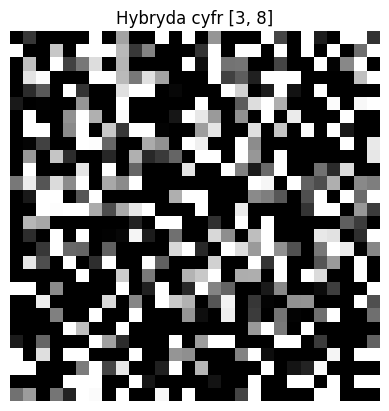

In [26]:
# choosing two digits
target_classes = [3, 8]

# initializing one image
hybrid_input = torch.randn((1, 1, 28, 28), device=device, requires_grad=True)

optimizer = torch.optim.Adam([hybrid_input], lr=0.01)

for step in range(3000):
    optimizer.zero_grad()

    normalized_input = (hybrid_input - mean_tensor) / std_tensor
    logits = net(normalized_input)
    probs = F.softmax(logits, dim=1)

    # Maksymalizujemy średnią prawdopodobieństw klas docelowych
    target_probs = probs[0, target_classes]

    # pobranie prawdopodobieństw klas 3 i 8
    prob3 = probs[0, target_classes[0]]
    prob8 = probs[0, target_classes[1]]

    # celem jest: prob3 ≈ 0.5, prob8 ≈ 0.5
    loss = (prob3 - 0.5) ** 2 + (prob8 - 0.5) ** 2

    loss.backward()
    optimizer.step()

    if step % 50 == 0 or step == 299:
        print(f"Step {step}\n"
          f"  Class {target_classes[0]}: {target_probs[0].item():.4f}\n"
          f"  Class {target_classes[1]}: {target_probs[1].item():.4f}\n"
          f"  Mean Target Prob: {target_probs.mean().item():.4f}")

# Denormalizacja i wizualizacja
hybrid_image_vis = hybrid_input.detach().cpu().clone()
hybrid_image_vis = hybrid_image_vis * std_dataset + mean_dataset
hybrid_image_vis = hybrid_image_vis.clamp(0, 1)

plt.imshow(hybrid_image_vis[0, 0], cmap='gray')
plt.axis('off')
plt.title(f"Hybryda cyfr {target_classes}")
plt.show()


probs[0, target_classes]

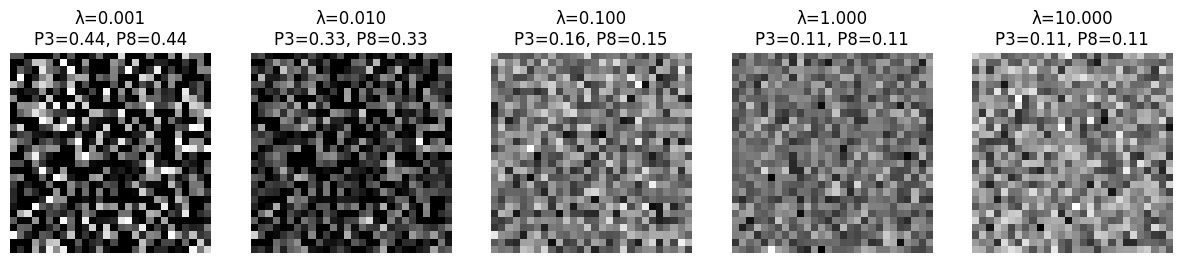

In [34]:
#porblem 2 z lambda
import torch.nn.functional as F
import matplotlib.pyplot as plt

target_classes = [3, 8]
lambda_values = [0.001, 0.01, 0.1, 1.0, 10.0]  # Exponential progression

fig, axs = plt.subplots(1, len(lambda_values), figsize=(15, 3))
#fig.suptitle("Effect of L2 Penalty on Hybrid Digit Images", fontsize=14)

hybrid_input = torch.randn((1, 1, 28, 28), device=device, requires_grad=True)
optimizer = torch.optim.Adam([hybrid_input], lr=0.1)


for i, lambda_l2 in enumerate(lambda_values):


    for step in range(3000):
        optimizer.zero_grad()
        normalized_input = (hybrid_input - mean_tensor) / std_tensor
        logits = net(normalized_input)
        probs = F.softmax(logits, dim=1)

        prob3 = probs[0, target_classes[0]]
        prob8 = probs[0, target_classes[1]]

        target_loss = (prob3 - 0.5) ** 2 + (prob8 - 0.5) ** 2
        l2_penalty = lambda_l2 * normalized_input.pow(2).mean()
        loss = target_loss + l2_penalty

        loss.backward()
        optimizer.step()

    # Denormalize for visualization
    img = hybrid_input.detach().cpu().clone()
    img = img * std_dataset + mean_dataset
    img = img.clamp(0, 1)

    axs[i].imshow(img[0, 0], cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(f"λ={lambda_l2:.3f}\nP3={prob3.item():.2f}, P8={prob8.item():.2f}")


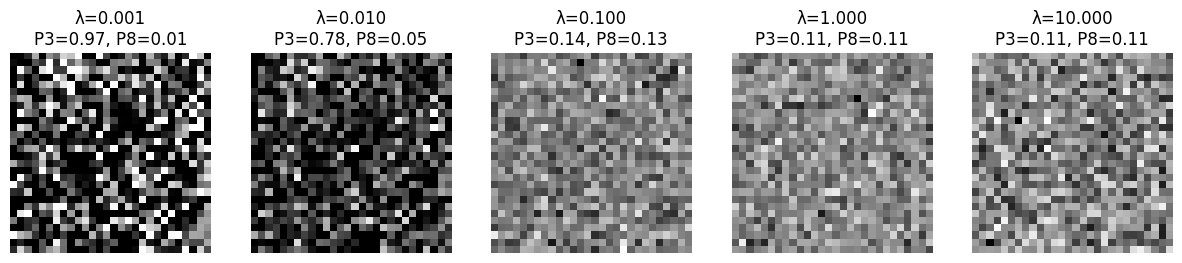

In [33]:
#porblem 2 z lambda
import torch.nn.functional as F
import matplotlib.pyplot as plt

target_classes = [3, 8]
lambda_values = [0.001, 0.01, 0.1, 1.0, 10.0]  # Exponential progression

fig, axs = plt.subplots(1, len(lambda_values), figsize=(15, 3))
#fig.suptitle("Effect of L2 Penalty on Hybrid Digit Images", fontsize=14)
hybrid_input = torch.randn((1, 1, 28, 28), device=device, requires_grad=True)
optimizer = torch.optim.Adam([hybrid_input], lr=0.1)

for i, lambda_l2 in enumerate(lambda_values):


    for step in range(3000):
        optimizer.zero_grad()
        normalized_input = (hybrid_input - mean_tensor) / std_tensor
        logits = net(normalized_input)
        probs = F.softmax(logits, dim=1)

        prob3 = probs[0, target_classes[0]]
        prob8 = probs[0, target_classes[1]]

        target_loss = - (prob3 + prob8) / 2.0
        l2_penalty = lambda_l2 * normalized_input.pow(2).mean()
        loss = target_loss + l2_penalty

        loss.backward()
        optimizer.step()

    # Denormalize for visualization
    img = hybrid_input.detach().cpu().clone()
    img = img * std_dataset + mean_dataset
    img = img.clamp(0, 1)

    axs[i].imshow(img[0, 0], cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(f"λ={lambda_l2:.3f}\nP3={prob3.item():.2f}, P8={prob8.item():.2f}")


Step 0, Loss: 2.3144, P(class): [0.102, 0.105, 0.1, 0.111, 0.106, 0.102, 0.107, 0.102, 0.109, 0.103]
Step 500, Loss: 0.1327, P(class): [0.102, 0.105, 0.1, 0.111, 0.106, 0.102, 0.107, 0.102, 0.109, 0.103]
Step 1000, Loss: 0.0944, P(class): [0.102, 0.105, 0.1, 0.111, 0.106, 0.102, 0.107, 0.102, 0.109, 0.103]
Step 1500, Loss: 0.0870, P(class): [0.102, 0.105, 0.1, 0.111, 0.106, 0.102, 0.107, 0.102, 0.109, 0.103]
Step 2000, Loss: 0.0821, P(class): [0.102, 0.105, 0.1, 0.111, 0.106, 0.102, 0.107, 0.102, 0.109, 0.103]
Step 2500, Loss: 0.0782, P(class): [0.102, 0.105, 0.1, 0.111, 0.106, 0.102, 0.107, 0.102, 0.109, 0.103]
Step 2999, Loss: 0.0753, P(class): [0.102, 0.105, 0.1, 0.111, 0.106, 0.102, 0.107, 0.102, 0.109, 0.103]
Step 0, Loss: 0.5869, P(class): [0.102, 0.105, 0.1, 0.111, 0.106, 0.102, 0.107, 0.102, 0.109, 0.103]
Step 500, Loss: 0.3496, P(class): [0.102, 0.105, 0.1, 0.111, 0.106, 0.102, 0.107, 0.102, 0.109, 0.103]
Step 1000, Loss: 0.3399, P(class): [0.102, 0.105, 0.1, 0.111, 0.106, 0.1

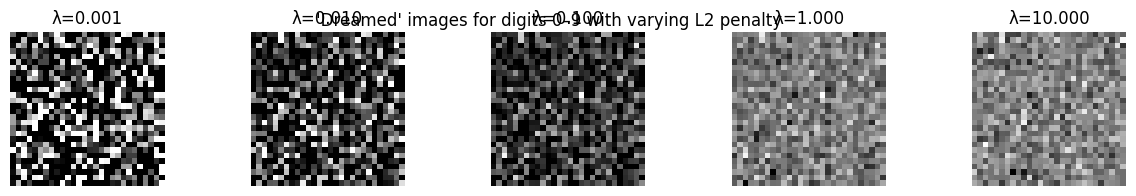

In [36]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Freeze the network weights (no training for the network)
net.eval()

# Initialize noise as input (10 images of size 28x28)
dreamed_inputs = torch.randn((10, 1, 28, 28), device=device, requires_grad=True)

# Set target classes as 0, 1, 2, ..., 9
target_classes = torch.arange(10, device=device)

# Optimizer for the input images
optimizer = torch.optim.Adam([dreamed_inputs], lr=0.01)

# Normalization parameters
mean_tensor = torch.tensor(mean_dataset, device=device)
std_tensor = torch.tensor(std_dataset, device=device)

# Lambda values for L2 penalty
lambda_values = [0.001, 0.01, 0.1, 1.0, 10.0]

# Set up the plot for visualizing the results
fig, axs = plt.subplots(1, len(lambda_values), figsize=(15, 2))

# Iterate through the different lambda values
for i, lambda_l2 in enumerate(lambda_values):

    # Reset optimizer for each lambda_l2 value
    optimizer = torch.optim.Adam([dreamed_inputs], lr=0.01)

    for step in range(3000):
        optimizer.zero_grad()

        # Normalize the input images
        normalized_input = (dreamed_inputs - mean_tensor) / std_tensor

        # Get the logits from the network for the input images
        logits = net(normalized_input)
        probs = F.softmax(logits, dim=1)

        # Extract the probabilities for the target classes (0 to 9)
        #prob_class = probs.gather(1, target_classes.view(-1, 1))

        # Compute the loss: maximize the probabilities for the target classes
        target_loss = F.cross_entropy(logits, target_classes)

        # L2 regularization penalty
        l2_penalty = lambda_l2 * normalized_input.pow(2).mean()

        # Total loss is the combination of target loss and L2 penalty
        loss = target_loss + l2_penalty

        # Backpropagate the loss
        loss.backward()
        optimizer.step()

        # Print loss and confidence values at certain steps
        if step % 500 == 0 or step == 2999:
            print(f"Step {step}, Loss: {loss.item():.4f}, P(class): {[round(p.item(), 3) for p in prob_class]}")

    # Denormalize the generated images for visualization
    img = dreamed_inputs.detach().cpu().clone()
    img = img * std_dataset + mean_dataset
    img = img.clamp(0, 1)

    # Visualize the generated images
    axs[i].imshow(img[0, 0], cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(f"λ={lambda_l2:.3f}")

# Display the results
plt.suptitle("'Dreamed' images for digits 0–9 with varying L2 penalty")
plt.show()



=== Lambda L2: 0.0 ===
[0] CE: 2.3496, L2: 10.6511, Total: 2.3496
Confidences: [0.111, 0.094, 0.08, 0.102, 0.102, 0.098, 0.073, 0.108, 0.09, 0.103]
[200] CE: 0.4326, L2: 27.0669, Total: 0.4326
Confidences: [0.762, 0.636, 0.626, 0.672, 0.702, 0.716, 0.475, 0.7, 0.646, 0.601]
[400] CE: 0.1302, L2: 46.0722, Total: 0.1302
Confidences: [0.926, 0.871, 0.864, 0.884, 0.911, 0.905, 0.801, 0.899, 0.875, 0.851]
[600] CE: 0.0618, L2: 59.6689, Total: 0.0618
Confidences: [0.963, 0.936, 0.935, 0.942, 0.957, 0.952, 0.903, 0.95, 0.939, 0.927]
[800] CE: 0.0364, L2: 70.2134, Total: 0.0364
Confidences: [0.977, 0.962, 0.962, 0.965, 0.974, 0.971, 0.942, 0.97, 0.963, 0.957]
[999] CE: 0.0242, L2: 78.9198, Total: 0.0242
Confidences: [0.985, 0.974, 0.975, 0.977, 0.982, 0.98, 0.962, 0.98, 0.975, 0.971]

=== Lambda L2: 0.001 ===
[0] CE: 2.3454, L2: 10.6766, Total: 2.3561
Confidences: [0.107, 0.094, 0.085, 0.094, 0.113, 0.095, 0.083, 0.12, 0.085, 0.088]
[200] CE: 0.4394, L2: 26.6855, Total: 0.4661
Confidences: [0

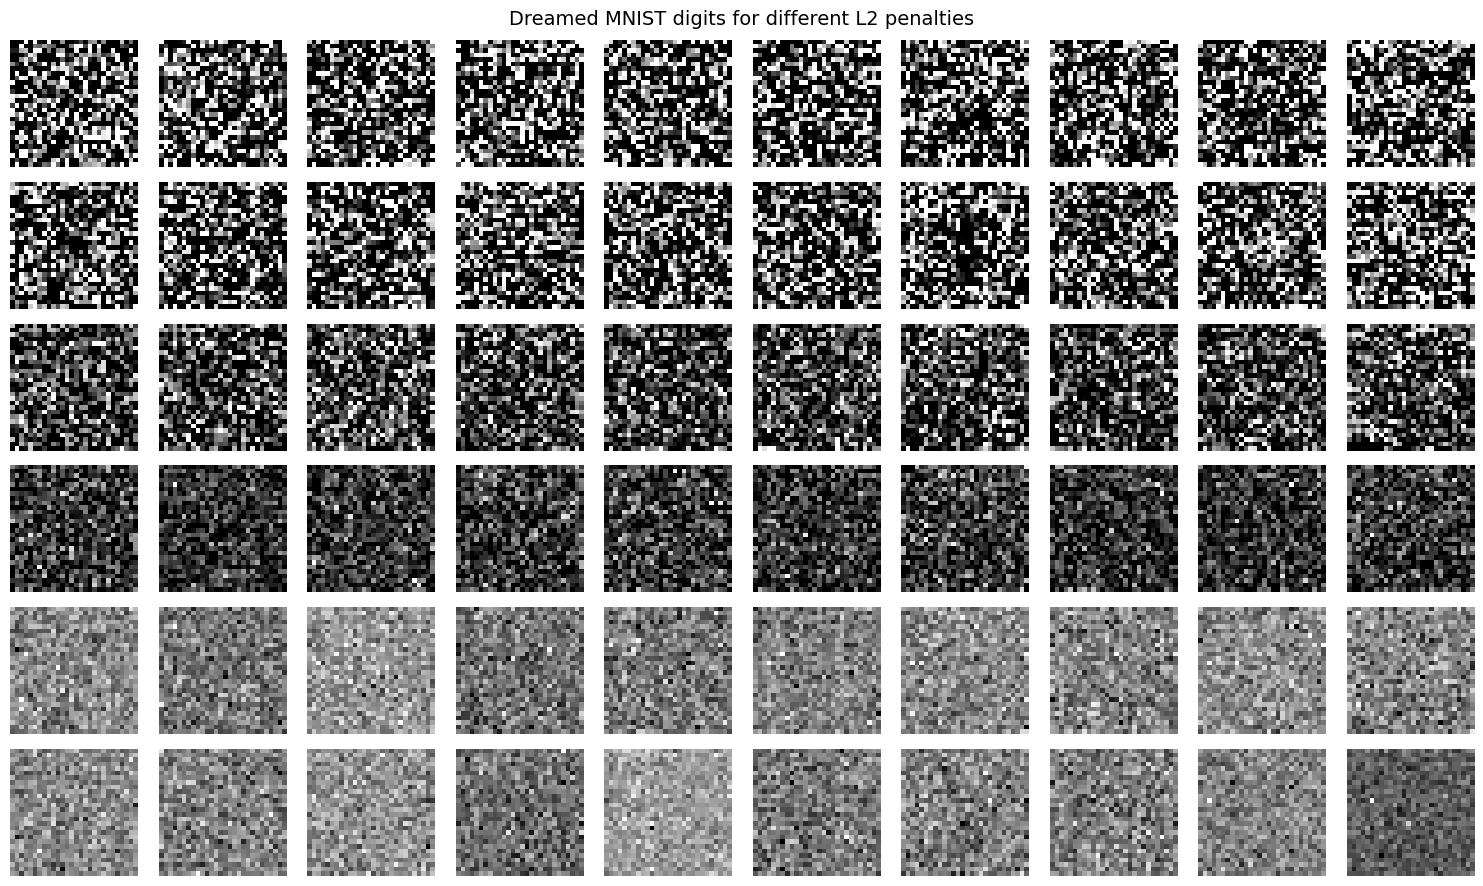

In [37]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Konfiguracja
net.eval()
for param in net.parameters():
    param.requires_grad = False

# Parametry
mean_dataset = 0.1307
std_dataset = 0.3081
device = next(net.parameters()).device

# Lista lambda L2 do przetestowania
lambda_l2_values = [0.0, 0.001, 0.01, 0.1, 1.0, 10.0]

# Przechowywanie wyników do wizualizacji
all_results = []

for lambda_l2 in lambda_l2_values:
    print(f"\n=== Lambda L2: {lambda_l2} ===")

    # Inicjalizacja wejść
    dreamed_inputs = torch.randn((10, 1, 28, 28), device=device, requires_grad=True)
    target_classes = torch.arange(10, device=device)
    optimizer = torch.optim.Adam([dreamed_inputs], lr=0.01)

    for step in range(1000):
        optimizer.zero_grad()
        normalized_inputs = (dreamed_inputs - mean_dataset) / std_dataset
        logits = net(normalized_inputs)

        # Strata: cross-entropy + kara L2
        ce_loss = F.cross_entropy(logits, target_classes)
        l2_loss = normalized_inputs.pow(2).mean()
        total_loss = ce_loss + lambda_l2 * l2_loss

        total_loss.backward()
        optimizer.step()

        if step % 200 == 0 or step == 999:
            with torch.no_grad():
                probs = F.softmax(logits, dim=1)
                max_probs = probs.gather(1, target_classes.view(-1, 1))
                print(f"[{step}] CE: {ce_loss.item():.4f}, L2: {l2_loss.item():.4f}, Total: {total_loss.item():.4f}")
                print("Confidences:", [round(p.item(), 3) for p in max_probs])

    # Odskalowanie i odcięcie wartości
    with torch.no_grad():
        vis = dreamed_inputs.detach().cpu() * std_dataset + mean_dataset
        vis = vis.clamp(0, 1)
        all_results.append((lambda_l2, vis))

# Wizualizacja
fig, axs = plt.subplots(len(all_results), 10, figsize=(15, 1.5 * len(all_results)))
for row_idx, (lambda_l2, images) in enumerate(all_results):
    for col_idx in range(10):
        ax = axs[row_idx, col_idx] if len(all_results) > 1 else axs[col_idx]
        ax.imshow(images[col_idx][0], cmap='gray')
        ax.axis('off')
        if col_idx == 0:
            ax.set_ylabel(f"λ={lambda_l2}", rotation=0, labelpad=30)
plt.suptitle("Dreamed MNIST digits for different L2 penalties", fontsize=14)
plt.tight_layout()
plt.show()


Step 0, Loss: 19.6347, Confidence: [0.0, 0.0, 0.0, 0.0, 0.0, 0.003, 0.0, 0.0, 0.0, 0.0], L2 Penalty: 0.0010
Step 50, Loss: 9.6052, Confidence: [0.0, 0.0, 0.77, 0.0, 0.0, 0.989, 0.0, 0.0, 0.0, 0.008], L2 Penalty: 0.0016
Step 100, Loss: 1.9890, Confidence: [0.003, 0.304, 0.977, 0.002, 0.63, 0.993, 0.015, 0.53, 0.221, 0.965], L2 Penalty: 0.0025
Step 150, Loss: 0.0582, Confidence: [0.847, 0.92, 0.986, 0.928, 0.967, 0.995, 0.937, 0.975, 0.944, 0.982], L2 Penalty: 0.0040
Step 200, Loss: 0.0294, Confidence: [0.959, 0.96, 0.99, 0.975, 0.98, 0.996, 0.97, 0.984, 0.971, 0.987], L2 Penalty: 0.0063
Step 250, Loss: 0.0254, Confidence: [0.975, 0.974, 0.993, 0.984, 0.986, 0.997, 0.979, 0.988, 0.98, 0.991], L2 Penalty: 0.0100
Step 300, Loss: 0.0272, Confidence: [0.983, 0.981, 0.994, 0.988, 0.99, 0.997, 0.985, 0.991, 0.986, 0.993], L2 Penalty: 0.0159
Step 350, Loss: 0.0340, Confidence: [0.987, 0.986, 0.996, 0.991, 0.992, 0.998, 0.988, 0.993, 0.989, 0.994], L2 Penalty: 0.0252
Step 400, Loss: 0.0470, Conf

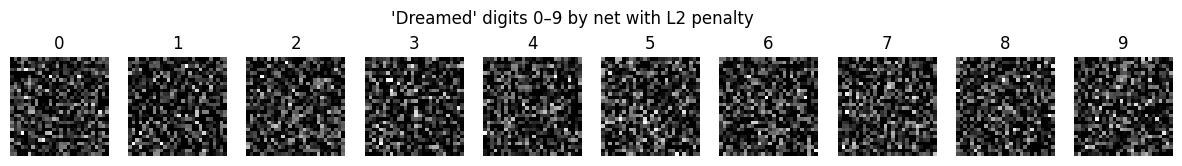

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# freezeing weights
net.eval()
for param in net.parameters():
    param.requires_grad = False

# gaussian noise as input
dreamed_inputs = torch.randn((10, 1, 28, 28), device=device, requires_grad=True)

# i-th image -> i-th number
target_classes = torch.arange(10, device=device)

# optimizer for input
optimizer = torch.optim.Adam([dreamed_inputs], lr=0.001)

# for further normalizing
mean_tensor = torch.tensor(mean_dataset, device=device)
std_tensor = torch.tensor(std_dataset, device=device)

# optimalization with L2 penalty
lambda_l2_start = 0.001
lambda_l2_end = 10.0
steps = 1000
for step in range(steps):
    optimizer.zero_grad()

    # Calculate the L2 penalty term
    lambda_l2 = lambda_l2_start * (lambda_l2_end / lambda_l2_start) ** (step / steps)  # exponential progression
    l2_penalty = lambda_l2 * dreamed_inputs.pow(2).mean()  # L2 penalty on noise

    # normalizing input
    normalized_inputs = (dreamed_inputs - mean_tensor) / std_tensor

    logits = net(normalized_inputs)
    loss = F.cross_entropy(logits, target_classes) + l2_penalty  # add L2 penalty to the loss

    loss.backward()
    optimizer.step()

    if step % 50 == 0 or step == 999:
        with torch.no_grad():
            probs = F.softmax(logits, dim=1)
            max_probs = probs.gather(1, target_classes.view(-1,1))
            print(f"Step {step}, Loss: {loss.item():.4f}, Confidence: {[round(p.item(), 3) for p in max_probs]}, L2 Penalty: {l2_penalty.item():.4f}")

# inversing normalization for visualization
dreamed_images_vis = dreamed_inputs.detach().cpu().clone()
dreamed_images_vis = dreamed_images_vis * std_dataset + mean_dataset
dreamed_images_vis = dreamed_images_vis.clamp(0, 1)

# visualization
fig, axs = plt.subplots(1, 10, figsize=(15, 2))
for i in range(10):
    axs[i].imshow(dreamed_images_vis[i][0], cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(str(i))
plt.suptitle(f"'Dreamed' digits 0–9 by net with L2 penalty")
plt.show()


Step 0, Loss: 2.2940, Confidence: [0.1, 0.114, 0.083, 0.117, 0.115, 0.096, 0.095, 0.106, 0.1, 0.087]
Step 50, Loss: 0.0542, Confidence: [0.961, 0.957, 0.94, 0.943, 0.97, 0.949, 0.901, 0.964, 0.963, 0.928]
Step 100, Loss: 0.0186, Confidence: [0.985, 0.983, 0.979, 0.981, 0.988, 0.983, 0.968, 0.986, 0.986, 0.977]
Step 150, Loss: 0.0109, Confidence: [0.991, 0.99, 0.988, 0.989, 0.993, 0.99, 0.982, 0.991, 0.991, 0.987]
Step 200, Loss: 0.0073, Confidence: [0.994, 0.993, 0.992, 0.993, 0.995, 0.993, 0.988, 0.994, 0.994, 0.991]
Step 250, Loss: 0.0054, Confidence: [0.995, 0.995, 0.994, 0.995, 0.997, 0.995, 0.991, 0.996, 0.996, 0.994]
Step 299, Loss: 0.0042, Confidence: [0.996, 0.996, 0.995, 0.996, 0.997, 0.996, 0.993, 0.997, 0.997, 0.995]


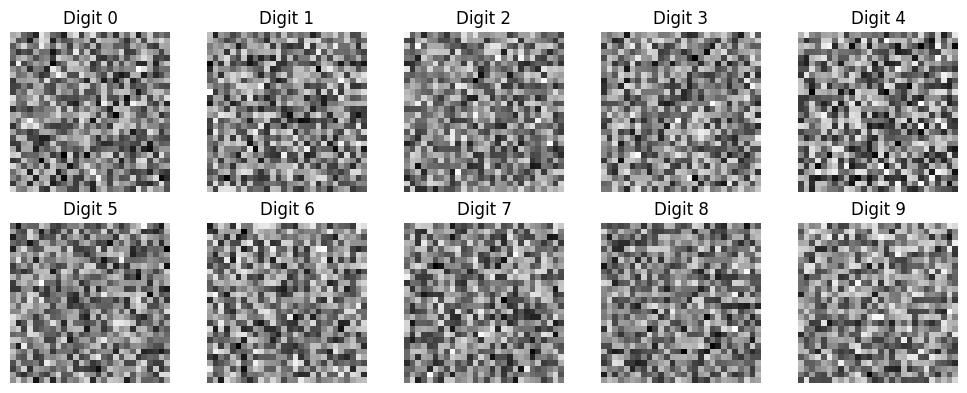

In [11]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Wczytaj wytrenowany model

net.eval()

# Obrazy do optymalizacji – po jednym na każdą cyfrę 0–9
dreamed_inputs = torch.randn((10, 1, 28, 28), device=device, requires_grad=True)

# Cele: chcemy, by sieć uznawała je za cyfry 0–9
targets = torch.arange(10, device=device)

# Optimizer dla *obrazów* (nie dla wag modelu!)
optimizer = torch.optim.Adam([dreamed_inputs], lr=0.1)

# Normalizacja danych MNIST – jak w Twoim trainloaderze
mean = trainset.data.numpy().mean() / 255.0
std = trainset.data.numpy().std() / 255.0

# Pętla optymalizacji obrazów
for step in range(300):
    optimizer.zero_grad()

    # Normalizacja jak w treningu
    normalized_inputs = (dreamed_inputs - mean) / std

    outputs = net(normalized_inputs)
    loss = F.cross_entropy(outputs, targets)

    loss.backward()
    optimizer.step()

    if step % 50 == 0 or step == 299:
        with torch.no_grad():
            probs = F.softmax(outputs, dim=1)
            max_probs = probs.gather(1, targets.view(-1, 1))
            print(f"Step {step}, Loss: {loss.item():.4f}, Confidence: {[round(p.item(), 3) for p in max_probs.view(-1)]}")


# Odwrócenie normalizacji do wizualizacji
final_images = dreamed_inputs.detach().cpu().clone()
final_images = final_images * std + mean  # undo normalization

# Wizualizacja wyników
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    img = final_images[i].squeeze().numpy()
    ax.imshow(img, cmap='gray')
    ax.set_title(f'Digit {i}')
    ax.axis('off')
plt.tight_layout()
plt.show()


Step 0, Loss: -0.4991, Class 3&5 Conf: [0.082, 0.099]
Step 50, Loss: -0.5000, Class 3&5 Conf: [0.1, 0.105]
Step 100, Loss: -0.5000, Class 3&5 Conf: [0.1, 0.105]
Step 150, Loss: -0.5000, Class 3&5 Conf: [0.1, 0.105]
Step 200, Loss: -0.5000, Class 3&5 Conf: [0.1, 0.105]
Step 250, Loss: -0.5000, Class 3&5 Conf: [0.1, 0.105]
Step 299, Loss: -0.5000, Class 3&5 Conf: [0.1, 0.105]


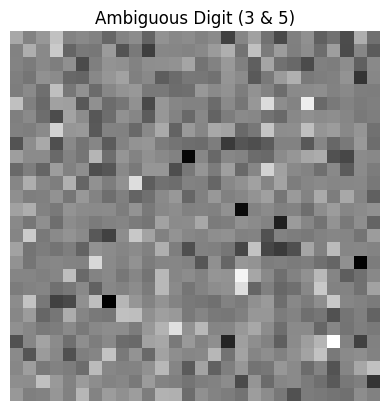

In [17]:
net.eval()

# Start from random image
ambiguous_image = torch.randn((1, 1, 28, 28), device=device, requires_grad=True)

# Target: mix between digit 3 and digit 5
target_classes = torch.tensor([9, 8], device=device)
target_probs = torch.tensor([0.5, 0.5], device=device)  # soft target

optimizer = torch.optim.Adam([ambiguous_image], lr=0.1)

# Normalization constants
mean = trainset.data.numpy().mean() / 255.0
std = trainset.data.numpy().std() / 255.0

for step in range(300):
    optimizer.zero_grad()

    normalized_input = (ambiguous_image - mean) / std
    logits = net(normalized_input)  # shape (1, 10)
    probs = F.softmax(logits, dim=1)

    # Extract predicted probs for classes 3 and 5
    selected_probs = probs[0, target_classes]

    # Loss: squared difference from [0.5, 0.5]
    loss = -target_probs.mean()


    # Optional: add small L2 penalty to keep pixel values reasonable
    l2_penalty = 0.001 * (ambiguous_image ** 2).mean()
    loss = loss + l2_penalty

    loss.backward()
    optimizer.step()

    if step % 50 == 0 or step == 299:
        with torch.no_grad():
            conf = [round(p.item(), 3) for p in selected_probs]
            print(f"Step {step}, Loss: {loss.item():.4f}, Class 3&5 Conf: {conf}")

# Unnormalize for visualization
img = ambiguous_image.detach().cpu().squeeze().numpy()
img = img * std + mean

plt.imshow(img, cmap='gray')
plt.title("Ambiguous Digit (3 & 5)")
plt.axis('off')
plt.show()